In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches

from HODLR import *

from IPython.display import clear_output

%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [3]:
m = 32 # number of mesh points
n = m**2
h = 1/m

x = np.arange(0,m)*h
y = np.arange(0,m)*h

κ = 2*np.pi*np.hstack([np.arange(0,m/2),np.arange(-m/2,0)])
delsq = -(κ**2 + κ[:,None]**2)
delsq[0,0] = 1


def A_matvec(f_flat):

    if f_flat.ndim == 1:
        f_flat = f_flat.reshape(-1,1)
        
    _,b = np.shape(f_flat)
    
    u_flat = np.zeros_like(f_flat)
    for i in range(b):
        
        fhat = sp.fft.fft2(f_flat[:,i].reshape(m,m))
        u = np.real(sp.fft.ifft2(fhat/delsq))
        u_flat[:,i] = u.reshape(-1)
        
    return u_flat

A = A_matvec(np.eye(m**2))

In [4]:
n_repeat = 20

ks = [1,5,10]
βs = np.geomspace(5e-2,.5,10)

names = ['GN1','GN2','RSVD1','RSVD2','GN1_nt','GN2_nt','RSVD1_nt','RSVD2_nt']

errs = {name:np.full((len(ks),len(βs),n_repeat),np.nan) for name in names}

err_opt = np.full(len(ks),np.nan)


for i,k in enumerate(ks):
    
    A_opt = opt_HODLR(A,k)
    err_opt[i] = np.linalg.norm(A-A_opt)

    for j,β in enumerate(βs):
        sr = int(k/β)
        sl = int(k/β**2)
        tr = int(1/β)
        tl = int(1/β)

        experiments = [{'name':'GN1','alg':GN_perf_peel,'params':[sr,1,sl,1,True]},\
                       {'name':'GN2','alg':GN_perf_peel,'params':[sr,tr,sl,1,True]},\
                       {'name':'RSVD1','alg':RSVD_perf_peel,'params':[sr,1,1,True]},\
                       {'name':'RSVD2','alg':RSVD_perf_peel,'params':[sr,tr,tl,True]},\
                       {'name':'GN1_nt','alg':GN_perf_peel,'params':[sr,1,sl,1,False]},\
                       {'name':'GN2_nt','alg':GN_perf_peel,'params':[sr,tr,sl,1,False]},\
                       {'name':'RSVD1_nt','alg':RSVD_perf_peel,'params':[sr,1,1,False]},\
                       {'name':'RSVD2_nt','alg':RSVD_perf_peel,'params':[sr,tr,tl,False]},\
                       ]
        for l in range(n_repeat):
            print(f'{i},{j},{l}: k={k} sr={sr} sl={sl}')
            clear_output(wait=True)

            for experiment in experiments:
                
                name = experiment['name']
                alg = experiment['alg']
                params = experiment['params']
                
                np.random.seed(l)
                A_tilde = alg(A_matvec,A_matvec,n,k,*params)

                errs[name][i,j,l] = implicit_err(A_matvec,A_tilde.matvec,n,min(n,2**15))

2,9,19: k=10 sr=20 sl=40


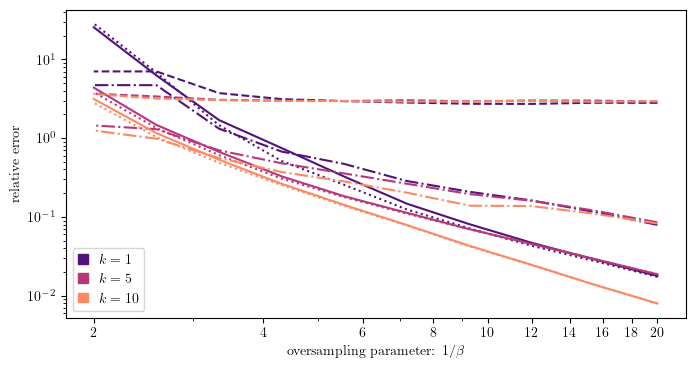

In [5]:
fig,axs = plt.subplots(1,1,figsize=(8,4),sharex=True,sharey=True)
fig.subplots_adjust(wspace=.1)

handles = []
for i,k in enumerate(ks):
    ax = axs
    
    c = plt.cm.magma((i+1)/(len(ks)+1))
    ax.plot(1/βs,np.mean(errs['GN1'][i]/err_opt[i]-1,axis=1),color=c)
    ax.plot(1/βs,np.mean(errs['GN2'][i]/err_opt[i]-1,axis=1),color=c,ls=':')
    ax.plot(1/βs,np.mean(errs['RSVD1'][i]/err_opt[i]-1,axis=1),color=c,ls='--')
    ax.plot(1/βs,np.mean(errs['RSVD2'][i]/err_opt[i]-1,axis=1),color=c,ls='-.')

    ax.set_xlabel(r'oversampling parameter: $1/\beta$')
    
    handles.append(mpatches.Patch(color=c,label=f'$k={k}$'))

plt.legend(handles=handles,loc='lower left',handlelength=0.7)

axs.set_ylabel('relative error')

axs.set_yscale('log')
axs.set_xscale('log')
axs.set_xticks(range(2,21,2))
axs.set_xticklabels(range(2,21,2))

plt.savefig('imgs/poisson_oversample.pdf')

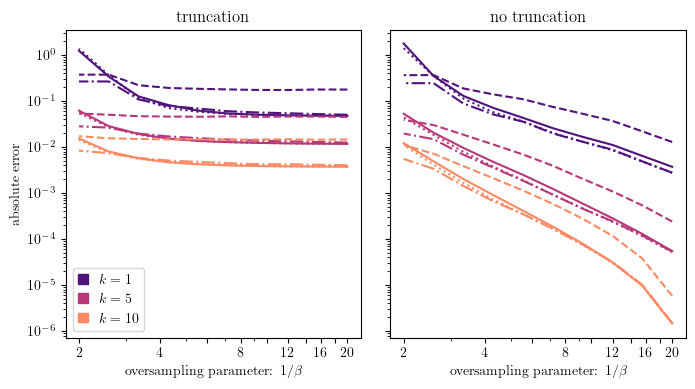

In [6]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
fig.subplots_adjust(wspace=.1)

handles = []
for i,k in enumerate(ks):
    c = plt.cm.magma((i+1)/(len(ks)+1))
    axs[0].plot(1/βs,np.mean(errs['GN1'][i],axis=1),color=c)
    axs[0].plot(1/βs,np.mean(errs['GN2'][i],axis=1),color=c,ls=':')
    axs[0].plot(1/βs,np.mean(errs['RSVD1'][i],axis=1),color=c,ls='--')
    axs[0].plot(1/βs,np.mean(errs['RSVD2'][i],axis=1),color=c,ls='-.')

    axs[1].plot(1/βs,np.mean(errs['GN1_nt'][i],axis=1),color=c)
    axs[1].plot(1/βs,np.mean(errs['GN2_nt'][i],axis=1),color=c,ls=':')
    axs[1].plot(1/βs,np.mean(errs['RSVD1_nt'][i],axis=1),color=c,ls='--')
    axs[1].plot(1/βs,np.mean(errs['RSVD2_nt'][i],axis=1),color=c,ls='-.')

    handles.append(mpatches.Patch(color=c,label=f'$k={k}$'))

axs[0].legend(handles=handles,loc='lower left',handlelength=0.7)

axs[0].set_title('truncation')
axs[1].set_title('no truncation')

axs[0].set_ylabel('absolute error')

for i in range(2):
    
    axs[i].set_xlabel(r'oversampling parameter: $1/\beta$')
    
    axs[i].set_yscale('log')
    axs[i].set_xscale('log')
    axs[i].set_xticks(range(2,21,2))
    axs[i].set_xticklabels([i if i%4==0 or i==2 else '' for i in range(2,21,2)])
    


plt.savefig('imgs/poisson_oversample_nt.pdf')